In [111]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transform
import torchvision.datasets as dsets
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
y = 100
import numpy as np
from tqdm import tqdm
from PIL import Image

In [112]:
from google.colab import drive

drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [113]:
from glob import glob
image_path = glob('/content/drive/MyDrive/deepDino/data/*.png')


In [114]:
train_path = image_path[0:150]
test_path = image_path[150:171]

In [115]:
print(plt.imread(train_path[0]).shape)

(105, 150, 3)


In [116]:
labels = ["UP","DOWN","RIGHT"]
for i in range(len(labels)):

  if "RIGHT" in image_path[0]:
    print("yes")

yes
yes
yes


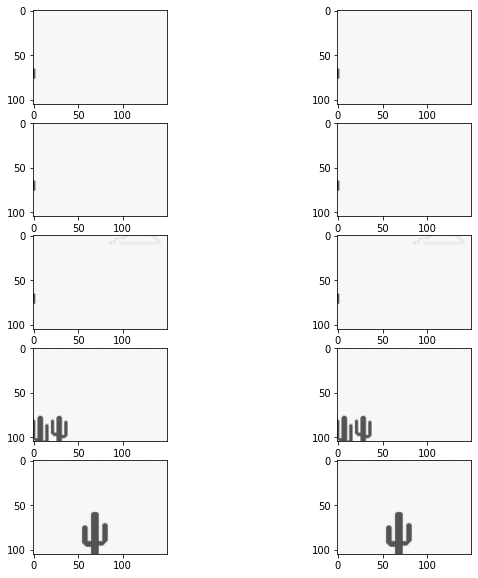

In [117]:
fix,ax = plt.subplots(5,2,figsize=(10,10))
for i in range(5):
  img = plt.imread(image_path[i])
  for j in range(2):
    ax[i][j].imshow(img )
  # plt.imshow(img)

In [118]:

class MyDataset(Dataset):
  def __init__(self,image_path,transform_image=None,transform_label=None):
    self.image_path = image_path
    self.transform_image = transform_image
    self.transform_label = transform_label
  def __len__(self):
    return (len(self.image_path))
  def __getitem__(self,i):
    labels = ["UP","DOWN","RIGHT"]
    img = Image.open(self.image_path[i])
    for j in range(len(labels)):
      if labels[j] in self.image_path[i]:
        label = j
    if self.transform_image is not None:
      image = self.transform_image(img)
    if self.transform_label is not None:
      label_new = self.transform_label(label)
    else:
      label_new = label
    return image,label_new



In [119]:
imageTransform = transform.Compose(
    [
        transform.ToTensor(),
        transform.Grayscale(),
        transform.Resize((100,100)),
        transform.RandomHorizontalFlip(p=0.85),
        
        
    ]
)
# labelTransform = transform.Compose(
#     [
#         transform.ToTensor(),
#     ]
# )

In [120]:
train_data = MyDataset(train_path,transform_image=imageTransform,transform_label=None)
test_data = MyDataset(test_path,transform_image=imageTransform,transform_label=None)
train_dataloader = DataLoader(train_data,5)
test_dataloader = DataLoader(test_data,1)


Feature batch shape: torch.Size([5, 1, 100, 100])
Labels batch shape: torch.Size([5])
tensor([2, 2, 2, 0, 0])


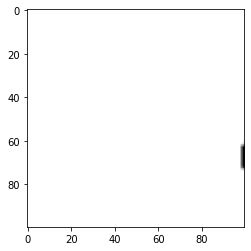

Label: 2


In [121]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(train_labels)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [122]:
print(train_data[0][0].shape)

torch.Size([1, 100, 100])


In [123]:
class Dino(nn.Module):
  def __init__(self,out1=20,out2=40,out3=60,classes=3):
    super().__init__()
    self.conLayers = nn.Sequential(
      nn.Conv2d(1,out_channels=out1,kernel_size=5,padding=2),
      nn.ReLU(),
      nn.BatchNorm2d(out1),
      nn.MaxPool2d(kernel_size=2),
      nn.Dropout(0.25),
      nn.Conv2d(in_channels=out1,out_channels=out2,kernel_size=5,padding=2),
      nn.ReLU(),
      nn.BatchNorm2d(out2),
      nn.MaxPool2d(kernel_size=2),
      nn.Dropout(0.25),
      nn.Flatten(),
      nn.Linear(out2*y*y//16,classes),
      
    )
  def forward(self,x):
    x = self.conLayers(x)
    return x

In [124]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [125]:
model = Dino().to(device)
lr = 0.0002
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
def train(model,img,label,optimizer,criterion):
  optimizer.zero_grad()
  out = model(img).to(device)
  # y_pred = torch.argmax(out,1)
  
  # print(y_pred)
  # print(out)
  # print(label)
  loss = criterion(out,label)
  # label.requires_grad = True
  loss.backward()
  optimizer.step()
  return loss.item()


In [126]:
print(model)

Dino(
  (conLayers): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=25000, out_features=3, bias=True)
  )
)


In [127]:
model_loss = []
for epoch in range(100):
  for img,label in tqdm(train_dataloader):
     label = label.type(torch.LongTensor)
     label = label.to(device)
     img = img.to(device)
     loss = train(model,img,label,optimizer,criterion)
     model_loss.append(loss)

100%|██████████| 30/30 [00:00<00:00, 69.52it/s]


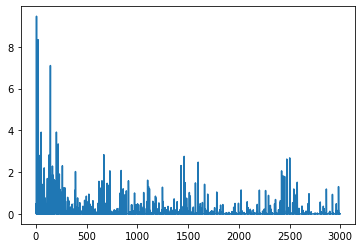

In [128]:
plt.plot(model_loss)

In [129]:
correct = 0
for img,lab in tqdm(test_dataloader):
  label = lab.type(torch.LongTensor)
  label = lab.to(device)
  img = img.to(device)
  output = model(img)
  y_pred = torch.argmax(output,1)
  if y_pred == label:
    correct +=1
  # print(y_pred,lab)
test_acc = correct/len(test_data)
print("The testing accuracy is: ",test_acc*100)

100%|██████████| 21/21 [00:00<00:00, 287.34it/s]

The testing accuracy is:  85.71428571428571
